In [5]:
import pandas as pd
import numpy as np

In [6]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [7]:
# Import train features dataset
train_X = pd.read_csv('/content/training_set_features.csv', index_col='respondent_id')
# Import train labels dataset
train_Y = pd.read_csv('/content/training_set_labels.csv', index_col='respondent_id')
# Import test features dataset
test_X = pd.read_csv('/content/test_set_features.csv', index_col='respondent_id')

In [8]:
# Numeric columns
num_cols = train_X.select_dtypes('number').columns

In [9]:
# Categorical columns
cat_cols = ['race', 'sex',
       'marital_status', 'rent_or_own',  'hhs_geo_region',
       'census_msa', 'employment_industry', 'employment_occupation']

In [10]:
# Ordinal columns
ord_cols = ['age_group', 'education',  'income_poverty',
        'employment_status']

In [11]:
train_df = train_X.join(train_Y)
print(train_df.shape)
train_df.head()

(26707, 37)


,xyz_concern,xyz_knowledge,behavioral_antiviral_meds,behavioral_avoidance,behavioral_face_mask,behavioral_wash_hands,behavioral_large_gatherings,behavioral_outside_home,behavioral_touch_face,doctor_recc_xyz,...,rent_or_own,employment_status,hhs_geo_region,census_msa,household_adults,household_children,employment_industry,employment_occupation,xyz_vaccine,seasonal_vaccine
respondent_id,,,,,,,,,,,,,,,,,,,,,
0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,...,Own,Not in Labor Force,oxchjgsf,Non-MSA,0.0,0.0,NaN,NaN,0,0
1,3.0,2.0,0.0,1.0,0.0,1.0,0.0,1.0,1.0,0.0,...,Rent,Employed,bhuqouqj,"MSA, Not Principle City",0.0,0.0,pxcmvdjn,xgwztkwe,0,1
2,1.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,NaN,...,Own,Employed,qufhixun,"MSA, Not Principle City",2.0,0.0,rucpziij,xtkaffoo,0,0
3,1.0,1.0,0.0,1.0,0.0,1.0,1.0,0.0,0.0,0.0,...,Rent,Not in Labor Force,lrircsnp,"MSA, Principle City",0.0,0.0,NaN,NaN,0,1
4,2.0,1.0,0.0,1.0,0.0,1.0,1.0,0.0,1.0,0.0,...,Own,Employed,qufhixun,"MSA, Not Principle City",1.0,0.0,wxleyezf,emcorrxb,0,0


In [12]:
train_df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 26707 entries, 0 to 26706
Data columns (total 37 columns):
 #   Column                       Non-Null Count  Dtype  
---  ------                       --------------  -----  
 0   xyz_concern                  26615 non-null  float64
 1   xyz_knowledge                26591 non-null  float64
 2   behavioral_antiviral_meds    26636 non-null  float64
 3   behavioral_avoidance         26499 non-null  float64
 4   behavioral_face_mask         26688 non-null  float64
 5   behavioral_wash_hands        26665 non-null  float64
 6   behavioral_large_gatherings  26620 non-null  float64
 7   behavioral_outside_home      26625 non-null  float64
 8   behavioral_touch_face        26579 non-null  float64
 9   doctor_recc_xyz              24547 non-null  float64
 10  doctor_recc_seasonal         24547 non-null  float64
 11  chronic_med_condition        25736 non-null  float64
 12  child_under_6_months         25887 non-null  float64
 13  health_worker        

In [13]:
import pandas as pd
from sklearn.metrics import classification_report, roc_curve, roc_auc_score, confusion_matrix, ConfusionMatrixDisplay
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder, OrdinalEncoder
import matplotlib.pyplot as plt

In [32]:
import optuna
from sklearn.model_selection import train_test_split, StratifiedKFold
from lightgbm import LGBMClassifier

In [33]:
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

In [34]:
# Separate features and labels
features = train_df.drop(['xyz_vaccine', 'seasonal_vaccine'], axis=1)
labels = train_df[['xyz_vaccine', 'seasonal_vaccine']]

# Define the column transformer for preprocessing
numeric_features = features.select_dtypes(include=['float64', 'int64']).columns
categorical_features = features.select_dtypes(include=['object']).columns

In [35]:
# Split the data into train and test sets with stratified sampling
X_train, X_eval, y_train, y_eval = train_test_split(features, labels, test_size=0.33, stratify=labels)

In [36]:
# Define the column transformer for preprocessing
preprocessor = ColumnTransformer(
    transformers=[
        ('categorical_encoder', OneHotEncoder(), cat_cols),
        ('ordinal_features', OrdinalEncoder(), ord_cols)
            ],
        remainder = 'passthrough',
        sparse_threshold=0)

In [37]:
def objective(trial, X, y):
    # Define the search space for hyperparameters
    param_grid = {
        'n_estimators'    : trial.suggest_int('n_estimators', 100, 500, step=25),
        "learning_rate"   : trial.suggest_float("learning_rate", 0.01, 0.15, step=0.0001),
        "max_depth"       : trial.suggest_int("max_depth", 3, 15),
        "reg_alpha"       : trial.suggest_float("reg_alpha", 0.01, 10, step=0.0001),
        "reg_lambda"      : trial.suggest_float("reg_lambda", 1, 100, step=0.0001),
        "subsample"       : trial.suggest_float("subsample", 0.05, 1, step=0.0001),
        "colsample_bytree": trial.suggest_float("colsample_bytree", 0.05, 1, step=0.0001),
        "class_weight"    : trial.suggest_categorical("class_weight", [None, "balanced"]),
    }

    # Define the LGBM classifier
    model = LGBMClassifier(**param_grid, boosting_type='gbdt', metric='auc', objective='binary', n_jobs=-1)

    # Define the pipeline
    pipeline = Pipeline([
        ('preprocessor', preprocessor),
        ('classifier', model)
        ])

    skf = StratifiedKFold(n_splits=5, shuffle=True)

    scores = []

    for train_idx, val_idx in skf.split(X, y):
        X_train_fold, X_val_fold = X.iloc[train_idx], X.iloc[val_idx]
        y_train_fold, y_val_fold = y.iloc[train_idx], y.iloc[val_idx]

        pipeline.fit(X_train_fold, y_train_fold)
        y_pred = pipeline.predict_proba(X_val_fold)[:, 1]
        score = roc_auc_score(y_val_fold, y_pred)
        scores.append(score)

    return np.mean(scores)

In [38]:
sampler = optuna.samplers.TPESampler(n_startup_trials=10)

In [39]:
# Perform optuna search to find the best hyperparameters for xyz_vaccine
study_xyz = optuna.create_study(direction='maximize', sampler=sampler)
func = lambda trial: objective(trial, X_train, y_train['xyz_vaccine'])
optuna.logging.set_verbosity(optuna.logging.WARNING)
study_xyz.optimize(func, n_trials=50, show_progress_bar=True)

[I 2024-06-17 13:51:21,479] A new study created in memory with name: no-name-6321856c-4abe-433c-9cd1-83548e621c78


  0%|          | 0/50 [00:00<?, ?it/s]

Streaming output truncated to the last 5000 lines.
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with posit

In [40]:
# important features from xyz model
optuna.importance.get_param_importances(study_xyz)

{'colsample_bytree': 0.6210350718647488,
 'learning_rate': 0.2935590016215037,
 'subsample': 0.05468616167759577,
 'n_estimators': 0.011143833577430162,
 'reg_lambda': 0.009461892198412744,
 'reg_alpha': 0.00707156935434122,
 'max_depth': 0.002488005647230283,
 'class_weight': 0.0005544640587372706}

In [41]:
import optuna.visualization as vis

In [42]:
# Plot parameter importance
vis.plot_param_importances(study_xyz)

In [43]:
# Get the best hyperparameters for h1n1_vaccine
best_params_h1n1 = study_xyz.best_params
print("Best Params for h1n1_vaccine:", best_params_h1n1)

Best Params for h1n1_vaccine: {'n_estimators': 350, 'learning_rate': 0.08549999999999999, 'max_depth': 6, 'reg_alpha': 4.5152, 'reg_lambda': 20.829900000000002, 'subsample': 0.8145000000000001, 'colsample_bytree': 0.3871, 'class_weight': None}


In [44]:
model_xyz = LGBMClassifier(**best_params_h1n1, boosting_type='gbdt', metric='auc', objective='binary', n_jobs=-1)

In [45]:

# Train the pipeline with the best hyperparameters for h1n1_vaccine
pipeline_xyz = Pipeline([
    ('preprocessor', preprocessor),
    ('classifier', LGBMClassifier(n_estimators      = best_params_h1n1['n_estimators'],
                                  learning_rate     = round(best_params_h1n1['learning_rate'],4),
                                  max_depth         = best_params_h1n1['max_depth'],
                                  reg_alpha         = round(best_params_h1n1['reg_alpha'],4),
                                  reg_lambda        = round(best_params_h1n1['reg_lambda'],4),
                                  subsample         = round(best_params_h1n1['subsample'],4),
                                  colsample_bytree  = round(best_params_h1n1['colsample_bytree'],4),
                                  class_weight      = best_params_h1n1['class_weight'],
                                  boosting_type='gbdt', metric='auc', objective='binary', n_jobs=-1))
])
pipeline_xyz.fit(X_train, y_train['xyz_vaccine'])

[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Info] Number of positive: 3802, number of negative: 14091
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.010057 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 258
[LightGBM] [Info] Number of data points in the train set: 17893, number of used features: 97
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.212485 -> initscore=-1.310009
[LightGBM] [Info] Start training from score -1.310009
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(remainder='passthrough', sparse_threshold=0,
                                   transformers=[('categorical_encoder',
                                                  OneHotEncoder(),
                                                  ['race', 'sex',
                                                   'marital_status',
                                                   'rent_or_own',
                                                   'hhs_geo_region',
                                                   'census_msa',
                                                   'employment_industry',
                                                   'employment_occupation']),
                                                 ('ordinal_features',
                                                  OrdinalEncoder(),
                                                  ['age_group', 'education',
                                                   'income_poverty',
                                                   'employment_status'])])),
                ('classifier',
                 LGBMClassifier(colsample_bytree=0.3871, learning_rate=0.0855,
                                max_depth=6, metric='auc', n_estimators=350,
                                n_jobs=-1, objective='binary', reg_alpha=4.5152,
                                reg_lambda=20.8299, subsample=0.8145))])

In [46]:
# Make predictions for xyz_vaccine
xyz_predictions = pipeline_xyz.predict(X_eval)
xyz_probabilities = pipeline_xyz.predict_proba(X_eval)[:, 1]  # Probability of positive class (1)

[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).


In [47]:
# Calculate ROC curve and ROC AUC score for xyz_vaccine
fpr, tpr, thresholds = roc_curve(y_eval['xyz_vaccine'], xyz_probabilities)
roc_auc_h1n1 = roc_auc_score(y_eval['xyz_vaccine'], xyz_probabilities)

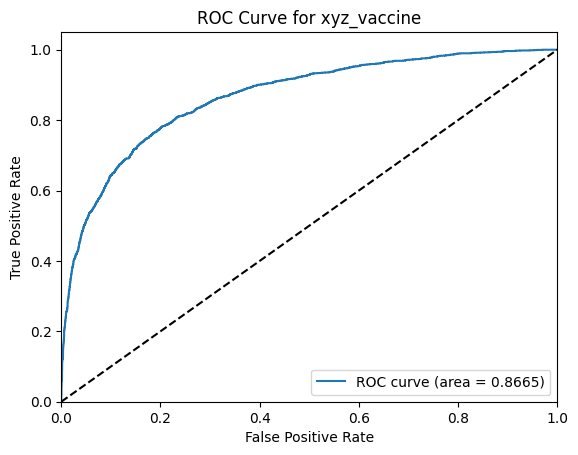

In [48]:
# Plot ROC curve for xyz_vaccine
plt.figure()
plt.plot(fpr, tpr, label='ROC curve (area = %0.4f)' % roc_auc_h1n1)
plt.plot([0, 1], [0, 1], 'k--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve for xyz_vaccine')
plt.legend(loc="lower right")
plt.show()

In [49]:
# Evaluate the model for h1n1_vaccine
print("h1n1_vaccine Classification Report:")
print(classification_report(y_eval['xyz_vaccine'], xyz_predictions))

h1n1_vaccine Classification Report:
              precision    recall  f1-score   support

           0       0.88      0.95      0.91      6942
           1       0.72      0.53      0.61      1872

    accuracy                           0.86      8814
   macro avg       0.80      0.74      0.76      8814
weighted avg       0.85      0.86      0.85      8814



In [50]:
# Compute the confusion matrix
cm_xyz = confusion_matrix(y_eval['xyz_vaccine'], xyz_predictions)
print(cm_xyz)

[[6565  377]
 [ 889  983]]


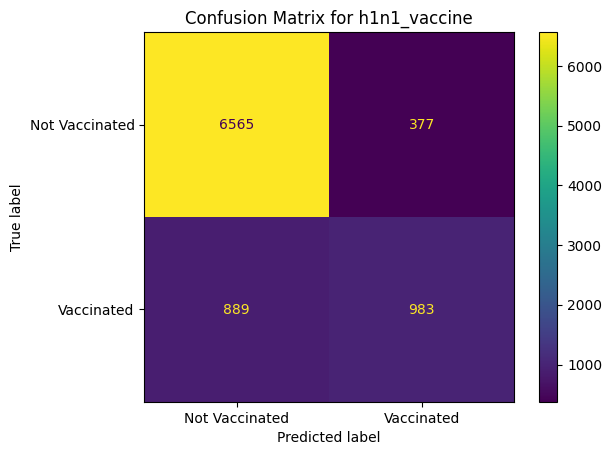

In [51]:
# Plot the confusion matrix
disp_h1n1 = ConfusionMatrixDisplay(confusion_matrix=cm_xyz, display_labels=['Not Vaccinated', 'Vaccinated'])
disp_h1n1.plot()
plt.title('Confusion Matrix for h1n1_vaccine')
plt.show()

In [52]:
# Perform optuna search to find the best hyperparameters for seasonal_vaccine
study_seasonal = optuna.create_study(direction='maximize', sampler=sampler)
func = lambda trial: objective(trial, X_train, y_train['seasonal_vaccine'])
optuna.logging.set_verbosity(optuna.logging.WARNING)
study_seasonal.optimize(func, n_trials=50, n_jobs=-1, show_progress_bar=True)

  0%|          | 0/50 [00:00<?, ?it/s]

In [53]:
# important features from seasonal model
optuna.importance.get_param_importances(study_seasonal)

{'colsample_bytree': 0.4382949445683107,
 'reg_lambda': 0.19634868386845003,
 'learning_rate': 0.1603461618528338,
 'n_estimators': 0.06770882779524054,
 'reg_alpha': 0.052732407891804445,
 'subsample': 0.052253179352793715,
 'max_depth': 0.02658751411794421,
 'class_weight': 0.0057282805526225455}

In [54]:
# Plot parameter importance
vis.plot_param_importances(study_seasonal)

In [55]:
# Get the best hyperparameters for seasonal_vaccine
best_params_seasonal = study_seasonal.best_params
print("Best Params for seasonal_vaccine:", best_params_seasonal)

Best Params for seasonal_vaccine: {'n_estimators': 500, 'learning_rate': 0.0998, 'max_depth': 6, 'reg_alpha': 5.5669, 'reg_lambda': 37.5494, 'subsample': 0.5833, 'colsample_bytree': 0.19190000000000002, 'class_weight': 'balanced'}


In [56]:
model_seasonal = LGBMClassifier(**best_params_seasonal, boosting_type='gbdt', metric='auc', objective='binary', n_jobs=-1)

In [57]:
# Train the pipeline with the best hyperparameters for seasonal_vaccine
pipeline_seasonal = Pipeline([
    ('preprocessor', preprocessor),
    ('classifier', LGBMClassifier(n_estimators      = best_params_seasonal['n_estimators'],
                                  learning_rate     = round(best_params_seasonal['learning_rate'],4),
                                  max_depth         = best_params_seasonal['max_depth'],
                                  reg_alpha         = round(best_params_seasonal['reg_alpha'],4),
                                  reg_lambda        = round(best_params_seasonal['reg_lambda'],4),
                                  subsample         = round(best_params_seasonal['subsample'],4),
                                  colsample_bytree  = round(best_params_seasonal['colsample_bytree'],4),
                                  class_weight      = best_params_seasonal['class_weight'],
                                  boosting_type='gbdt', metric='auc', objective='binary', n_jobs=-1))
])
pipeline_seasonal.fit(X_train, y_train['seasonal_vaccine'])

[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Info] Number of positive: 8331, number of negative: 9562
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.004136 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 258
[LightGBM] [Info] Number of data points in the train set: 17893, number of used features: 97
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=-0.000000
[LightGBM] [Info] Start training from score -0.000000
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further spl

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(remainder='passthrough', sparse_threshold=0,
                                   transformers=[('categorical_encoder',
                                                  OneHotEncoder(),
                                                  ['race', 'sex',
                                                   'marital_status',
                                                   'rent_or_own',
                                                   'hhs_geo_region',
                                                   'census_msa',
                                                   'employment_industry',
                                                   'employment_occupation']),
                                                 ('ordinal_features',
                                                  OrdinalEncoder(),
                                                  ['age_group', 'education',
                                                   'income_poverty',
                                                   'employment_status'])])),
                ('classifier',
                 LGBMClassifier(class_weight='balanced',
                                colsample_bytree=0.1919, learning_rate=0.0998,
                                max_depth=6, metric='auc', n_estimators=500,
                                n_jobs=-1, objective='binary', reg_alpha=5.5669,
                                reg_lambda=37.5494, subsample=0.5833))])

In [58]:
# Make predictions for seasonal_vaccine
seasonal_predictions = pipeline_seasonal.predict(X_eval)
seasonal_probabilities = pipeline_seasonal.predict_proba(X_eval)[:, 1]  # Probability of positive class (1)

[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).


In [59]:
# Calculate ROC curve and ROC AUC score for seasonal
fpr, tpr, thresholds = roc_curve(y_eval['seasonal_vaccine'], seasonal_probabilities)
roc_auc_seasonal = roc_auc_score(y_eval['seasonal_vaccine'], seasonal_probabilities)

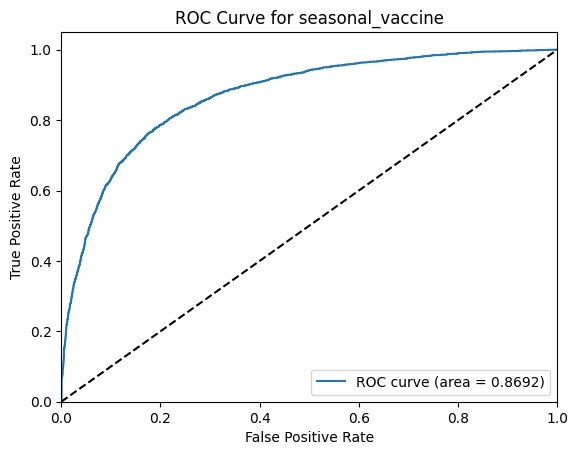

In [60]:
# Plot ROC curve for seasonal_vaccine
plt.figure()
plt.plot(fpr, tpr, label='ROC curve (area = %0.4f)' % roc_auc_seasonal)
plt.plot([0, 1], [0, 1], 'k--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve for seasonal_vaccine')
plt.legend(loc="lower right")
plt.show()

In [61]:
# Evaluate the model for seasonal_vaccine
print("seasonal_vaccine Classification Report:")
print(classification_report(y_eval['seasonal_vaccine'], seasonal_predictions))

seasonal_vaccine Classification Report:
              precision    recall  f1-score   support

           0       0.81      0.81      0.81      4710
           1       0.78      0.78      0.78      4104

    accuracy                           0.79      8814
   macro avg       0.79      0.79      0.79      8814
weighted avg       0.79      0.79      0.79      8814



In [62]:
# Compute the confusion matrix
cm_seasonal = confusion_matrix(y_eval['seasonal_vaccine'], seasonal_predictions)
print(cm_seasonal)

[[3801  909]
 [ 904 3200]]


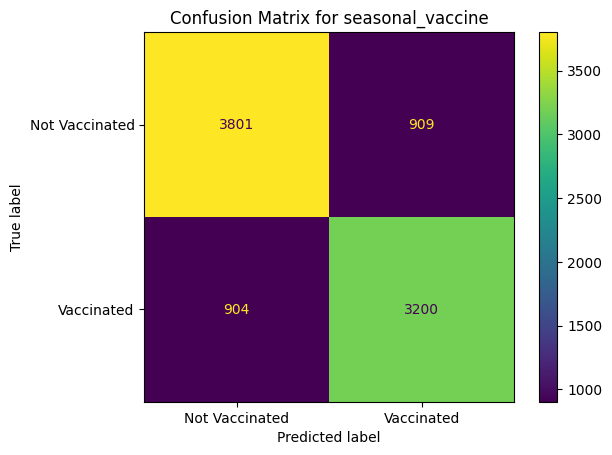

In [63]:
# Plot the confusion matrix
disp_seasonal = ConfusionMatrixDisplay(confusion_matrix=cm_seasonal, display_labels=['Not Vaccinated', 'Vaccinated'])
disp_seasonal.plot()
plt.title('Confusion Matrix for seasonal_vaccine')
plt.show()


In [64]:
# Calculate average ROC AUC score
average_roc_auc = (roc_auc_h1n1 + roc_auc_seasonal) / 2

# Print the average ROC AUC score
print("Average ROC AUC Score:", average_roc_auc)

Average ROC AUC Score: 0.8678174492935752


In [65]:
%%time

# Training xyz pipeline on full train dataset
pipeline_xyz.fit(train_X, train_Y['xyz_vaccine'])

None   # So we don't print out the whole pipeline representation

[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Info] Number of positive: 5674, number of negative: 21033
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.332816 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 258
[LightGBM] [Info] Number of data points in the train set: 26707, number of used features: 97
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.212454 -> initscore=-1.310198
[LightGBM] [Info] Start training from score -1.310198
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further sp

In [66]:
# Want to see top 10 features
N = 10

In [67]:
a = train_X
b = train_Y['xyz_vaccine']

# transform the train by using the data cleaning stuff above to fill in missing data and create dummy variables
processed_data = preprocessor.fit_transform(a, b)

categorical_feature_names = preprocessor.named_transformers_['categorical_encoder'].get_feature_names_out(cat_cols)

all_feature_names = list(numeric_features) + list(categorical_feature_names) + list(ord_cols)

# Convert the processed data array back into a DataFrame
X_xyz_train = pd.DataFrame(processed_data, columns=all_feature_names)

In [68]:
# Get feature importances for h1n1_vaccine model
importance_xyz = pipeline_xyz.named_steps['classifier'].feature_importances_

# Create a DataFrame to show feature importances
feature_importances_xyz = pd.DataFrame({'Feature': X_xyz_train.columns, 'Importance': importance_xyz})
# Sort by importance in descending order
feature_importances_xyz = feature_importances_xyz.sort_values(by='Importance', ascending=False)

# Display the top N most important features for h1n1_vaccine model
print("Feature Importances for xyz_vaccine:")
print(feature_importances_xyz.head(N))

Feature Importances for xyz_vaccine:
                           Feature  Importance
93       employment_occupation_nan         471
91  employment_occupation_xtkaffoo         465
92  employment_occupation_xzmlyyjv         456
94                       age_group         438
90  employment_occupation_xqwwgdyp         430
72  employment_occupation_cmhcxjea         419
95                       education         406
73  employment_occupation_dcjcmpih         396
71  employment_occupation_ccgxvspp         378
96                  income_poverty         343


In [69]:
%%time

# Training seasonal pipeline on full train dataset
pipeline_seasonal.fit(train_X, train_Y['seasonal_vaccine'])

None   # So we don't print out the whole pipeline representation

[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Info] Number of positive: 12435, number of negative: 14272
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.006444 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 258
[LightGBM] [Info] Number of data points in the train set: 26707, number of used features: 97
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000
[LightGBM] [Info] Start training from score 0.000000
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further spl

In [70]:
a = train_X
b = train_Y['seasonal_vaccine']

# transform the train by using the data cleaning stuff above to fill in missing data and create dummy variables
processed_data = preprocessor.fit_transform(a, b)


categorical_feature_names = preprocessor.named_transformers_['categorical_encoder'].get_feature_names_out(cat_cols)

all_feature_names = list(numeric_features) + list(categorical_feature_names) + list(ord_cols)

# Convert the processed data array back into a DataFrame
X_seasonal_train = pd.DataFrame(processed_data, columns=all_feature_names)

In [71]:
# Get feature importances for seasonal_vaccine model
importance_seasonal = pipeline_seasonal.named_steps['classifier'].feature_importances_

# Create a DataFrame to show feature importances
feature_importances_seasonal = pd.DataFrame({'Feature': X_seasonal_train.columns, 'Importance': importance_seasonal})
# Sort by importance in descending order
feature_importances_seasonal = feature_importances_seasonal.sort_values(by='Importance', ascending=False)

# Display the top N most important features for seasonal_vaccine model
print("Feature Importances for seasonal_vaccine:")
print(feature_importances_seasonal.head(N))

Feature Importances for seasonal_vaccine:
                           Feature  Importance
96                  income_poverty         728
90  employment_occupation_xqwwgdyp         598
95                       education         478
94                       age_group         471
91  employment_occupation_xtkaffoo         454
93       employment_occupation_nan         446
92  employment_occupation_xzmlyyjv         441
72  employment_occupation_cmhcxjea         429
74  employment_occupation_dlvbwzss         318
71  employment_occupation_ccgxvspp         288


In [72]:
test_probas_xyz = pipeline_xyz.predict_proba(test_X)
test_probas_xyz

[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).


array([[0.87872651, 0.12127349],
       [0.96054219, 0.03945781],
       [0.78926529, 0.21073471],
       ...,
       [0.8295579 , 0.1704421 ],
       [0.97736574, 0.02263426],
       [0.4265212 , 0.5734788 ]])

In [73]:
test_probas_seasonal = pipeline_seasonal.predict_proba(test_X)
test_probas_seasonal

[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).


array([[0.73070683, 0.26929317],
       [0.96712016, 0.03287984],
       [0.2087602 , 0.7912398 ],
       ...,
       [0.76926556, 0.23073444],
       [0.71028613, 0.28971387],
       [0.35776592, 0.64223408]])

In [74]:
submission_df = pd.read_csv("/content/submission_format.csv", index_col="respondent_id")

In [75]:
submission_df.head()

,h1n1_vaccine,seasonal_vaccine
respondent_id,,
26707,0.5,0.7
26708,0.5,0.7
26709,0.5,0.7
26710,0.5,0.7
26711,0.5,0.7


In [78]:
submission_df.drop('h1n1_vaccine', axis=1, inplace=True)

In [79]:
# Make sure we have the rows in the same order
np.testing.assert_array_equal(test_X.index.values, submission_df.index.values)

# Save predictions to submission data frame
submission_df["xyz_vaccine"] = test_probas_xyz[:, 1]
submission_df["seasonal_vaccine"] = test_probas_seasonal[:, 1]

submission_df.head()

,seasonal_vaccine,xyz_vaccine
respondent_id,,
26707,0.269293,0.121273
26708,0.032880,0.039458
26709,0.791240,0.210735
26710,0.899045,0.703056
26711,0.520749,0.256331


In [80]:
submission_df.to_csv('/content/submission_format.csv', index=True)

In [ ]:
!pip3 install optuna

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 380.1/380.1 kB 7.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 233.4/233.4 kB 27.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 78.6/78.6 kB 10.7 MB/s eta 0:00:00


In [31]:
!pip3 install optuna


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 380.1/380.1 kB 6.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 233.4/233.4 kB 10.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 78.6/78.6 kB 11.0 MB/s eta 0:00:00
